<ipython-input-49-cb39d54c098d>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


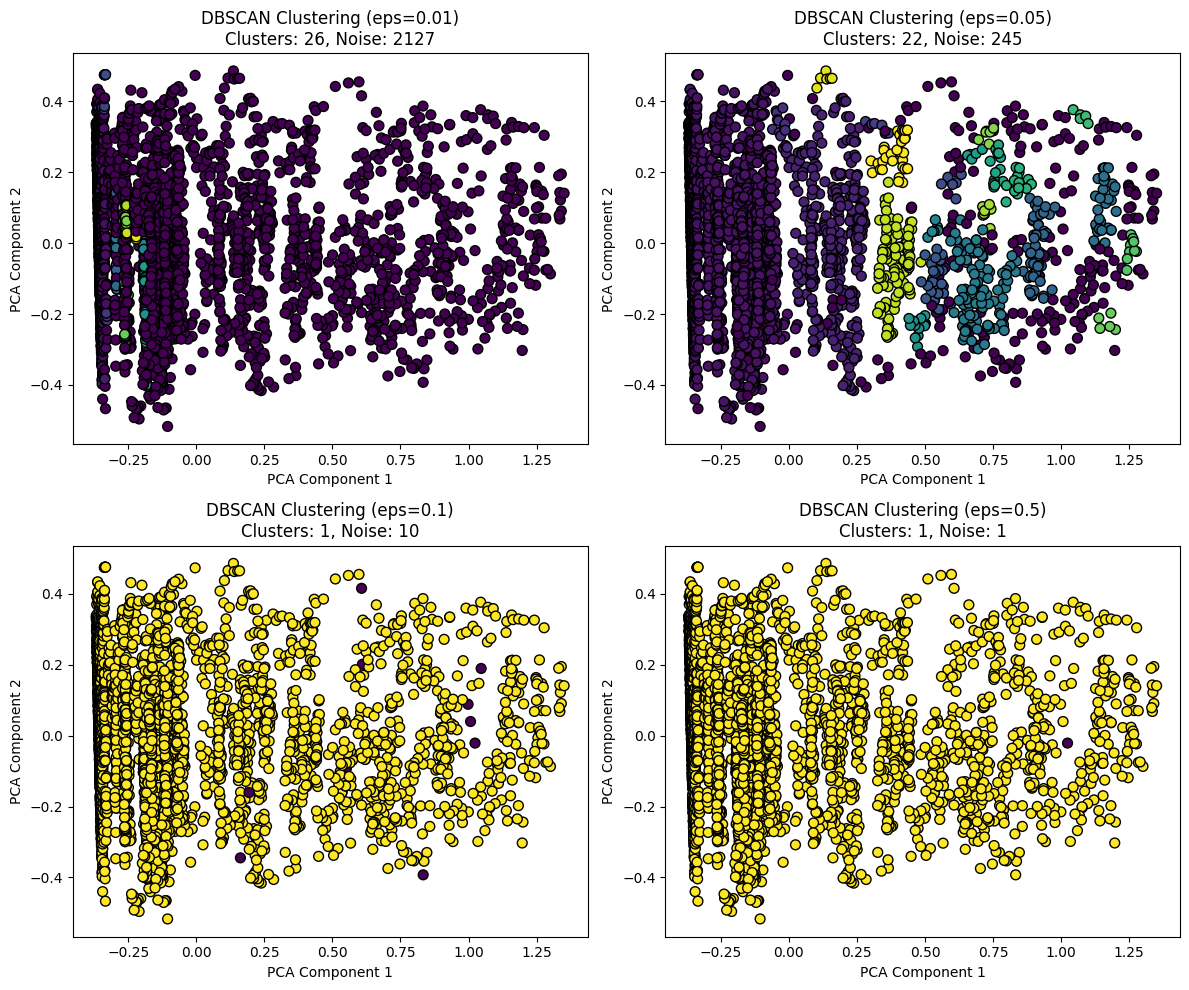

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

df = pd.read_csv('BTC-USD.csv')
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)

df['SMA_7'] = df['Close'].rolling(window=7).mean()
df['EMA_14'] = df['Close'].ewm(span=14, adjust=False).mean()

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0.0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0.0)).rolling(window=window).mean()
    rs = gain / (loss + 1e-8)
    return 100.0 - (100.0 / (1.0 + rs))

df['RSI_14'] = compute_rsi(df['Close'], 14)
df.fillna(method='bfill', inplace=True)

# Features for clustering
feature_cols = ['Close', 'Volume', 'SMA_7', 'EMA_14', 'RSI_14']
df_features = df[feature_cols].copy()

# Scaling
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_features)

# Hyperparameter (EPS)
eps_values = [0.01, 0.05, 0.1, 0.5]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

for i, eps in enumerate(eps_values):
    dbscan = DBSCAN(eps=eps, min_samples=5)
    clusters = dbscan.fit_predict(df_scaled)

    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise = list(clusters).count(-1)

    # Plot results
    axes[i].scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
    axes[i].set_title(f'DBSCAN Clustering (eps={eps})\nClusters: {n_clusters}, Noise: {n_noise}')
    axes[i].set_xlabel('PCA Component 1')
    axes[i].set_ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

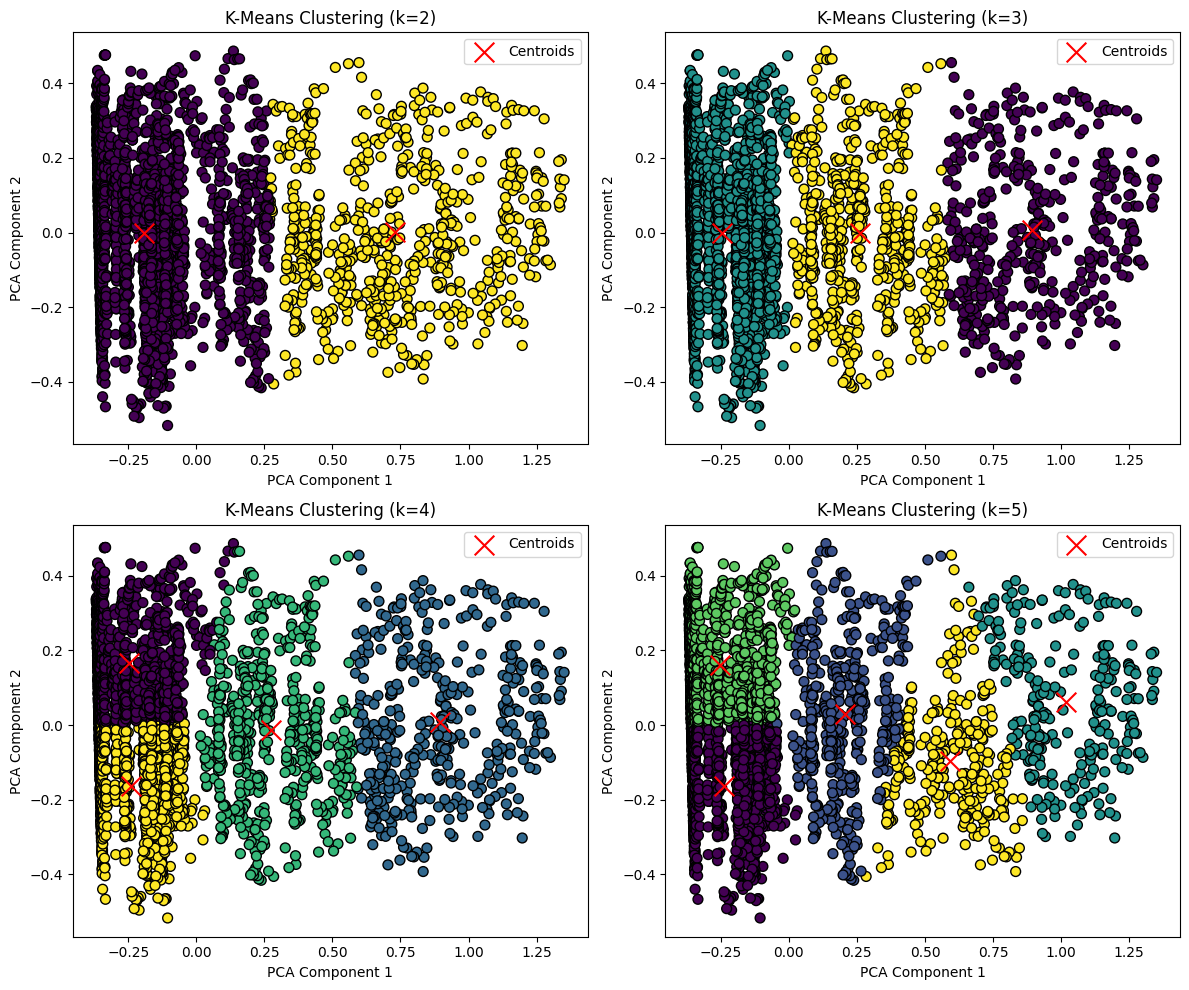

In [ ]:
from sklearn.cluster import KMeans

# KMeans

# Hyperparameter (clusters)
k_values = [2, 3, 4, 5]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, n_init=10)
    clusters = kmeans.fit_predict(df_scaled)

    # Transform centroids using PCA
    centroids_pca = pca.transform(kmeans.cluster_centers_)

    # Plot results
    axes[i].scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
    axes[i].scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='x', s=200, label='Centroids')
    axes[i].set_title(f'K-Means Clustering (k={k})')
    axes[i].set_xlabel('PCA Component 1')
    axes[i].set_ylabel('PCA Component 2')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
feature_cols = ['Close', 'Volume', 'SMA_7', 'EMA_14', 'RSI_14']
df_features = df[feature_cols].copy()

# Determine number of samples in dataset
n_samples = len(df_features)

# split dataset into training, val, and test
train_size = int(n_samples * 0.8)
val_size = int(n_samples * 0.1)
test_size = n_samples - train_size - val_size

# Create train, validation, and test datasets
train_df = df_features.iloc[:train_size]
val_df = df_features.iloc[train_size:train_size + val_size]
test_df = df_features.iloc[train_size + val_size:]

print("Train set:", train_df.shape)
print("Val set:  ", val_df.shape)
print("Test set: ", test_df.shape)

Train set: (2582, 5)
Val set:   (322, 5)
Test set:  (324, 5)


In [ ]:
# initialze minmaxscaler and fit to training data
scaler = MinMaxScaler()
scaler.fit_transform(train_df.values)

# transform train, validation, and test sets using the fitted scaler
train_scaled = scaler.transform(train_df.values)
val_scaled = scaler.transform(val_df.values)
test_scaled = scaler.transform(test_df.values)

# Add K-Means clustering (k=5)
all_scaled = np.vstack([train_scaled, val_scaled, test_scaled])
kmeans = KMeans(n_clusters=5, n_init=10)
cluster_labels = kmeans.fit_predict(all_scaled)

df_features['Cluster'] = cluster_labels

df_features.head()

,Close,Volume,SMA_7,EMA_14,RSI_14,Cluster
0,457.334015,21056800,417.462572,457.334015,31.997433,0
1,424.440002,34483200,417.462572,452.948147,31.997433,0
2,394.795990,37919700,417.462572,445.194526,31.997433,0
3,408.903992,36863600,417.462572,440.355788,31.997433,0
4,398.821014,26580100,417.462572,434.817818,31.997433,0


In [ ]:
# Split data with clusters feature
train_df = df_features.iloc[:train_size]
val_df = df_features.iloc[train_size:train_size + val_size]
test_df = df_features.iloc[train_size + val_size:]

# Combine scaled features + cluster feature
train_scaled_with_cluster = np.hstack([train_scaled, train_df[['Cluster']].values])
val_scaled_with_cluster = np.hstack([val_scaled, val_df[['Cluster']].values])
test_scaled_with_cluster = np.hstack([test_scaled, test_df[['Cluster']].values])

In [ ]:
def make_windows(data, window_size=30, horizon=1):
    """
    Create sliding windows from ts data.

    Parameters:
     - data: NumPy array of shape (num_samples, num_features)
     - window_size: how many past time steps used as input
     - horizon: how many future time steps to predict
    Returns: X, y
     - X: (num_samples, window_size, num_features)
     - y: (num_samples, horizon) -> for multi-step, or (num_samples,) if horizon=1
    """
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i: i+window_size])
        y.append(data[i+window_size: i+window_size+horizon, 0])
    X = np.array(X)
    y = np.array(y)
    return X, y

window_size = 30 # Past 30 days as input
horizon = 1  # Predict 1 day ahead

# Create dataset instances for training, validation, and testing
X_train, y_train = make_windows(train_scaled_with_cluster, window_size=window_size, horizon=horizon)
X_val, y_val = make_windows(val_scaled_with_cluster, window_size=window_size, horizon=horizon)
X_test, y_test = make_windows(test_scaled_with_cluster, window_size=window_size, horizon=horizon)

In [ ]:
# Reshape X for SVR
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# SVR model
svr = SVR(kernel='rbf', C=100, gamma='auto')
svr.fit(X_train_flat, y_train)

# Predict on test set
y_pred = svr.predict(X_test_flat)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test MSE (real scale):   15327695.791871736
Test RMSE (real scale):  3915.0601262141217
Test MAE (real scale):   3548.0792719745186
Test MAPE (real scale):  16.445775973451866


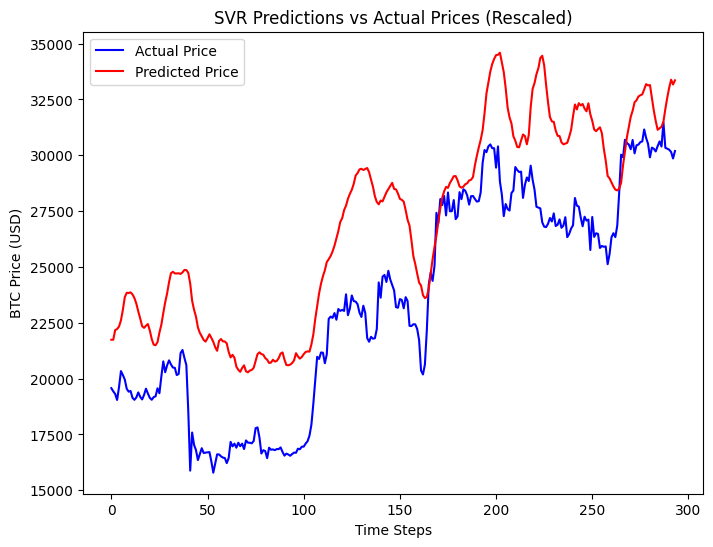

In [ ]:
# Invert scaling for real price values
# We only invert the 'Close' column.
# So we create a dummy array for inverse transform.

def inverse_transform_close(scaled_close):
    """
    scaled_close: shape (N,)
    Returns: real BTC prices
    """
    # We create a 2D array of zeros with the same number of columns as we had in training
    # Fill the first column with scaled_close, then invert transform
    dummy = np.zeros((len(scaled_close), len(feature_cols)))
    dummy[:, 0] = scaled_close  # place it in 'Close' position
    dummy_inverted = scaler.inverse_transform(dummy)
    return dummy_inverted[:, 0]  # return only 'Close' column


inverse_preds = inverse_transform_close(y_pred.ravel())
inverse_test = inverse_transform_close(y_test.ravel())

# first value is NaN because of n_lags
inverse_preds[0] = inverse_preds[1]

# Evaluations
mse = np.mean((inverse_preds - inverse_test) ** 2)
rmse = math.sqrt(mse)
mae = np.mean(np.abs(inverse_preds - inverse_test))
mape = np.mean(np.abs((inverse_preds - inverse_test) / (inverse_test + 1e-8))) * 100

print("Test MSE (real scale):  ", mse)
print("Test RMSE (real scale): ", rmse)
print("Test MAE (real scale):  ", mae)
print("Test MAPE (real scale): ", mape)

# Plot predictions
plt.figure(figsize=(8, 6))
plt.plot(range(len(inverse_test)), inverse_test, label='Actual Price', color='blue')
plt.plot(range(len(inverse_preds)), inverse_preds, label='Predicted Price', color='red')
plt.xlabel('Time Steps')
plt.ylabel('BTC Price (USD)')
plt.title('SVR Predictions vs Actual Prices (Rescaled)')
plt.legend()
plt.show()